# **ЗАДАНИЕ 8. ПОСТРОЕНИЕ МОДЕЛИ ARIMA**
Постройте модель ARIMA для временного ряда цен на материал 3. Рассчитайте показатели точности и адекватности построенной модели. Дайте точечный и интервальный прогнозы на 1 год вперёд по построенной модели.
Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.

In [ ]:
!pip install --upgrade xlrd

In [ ]:
!pip install statsmodels --upgrade

In [ ]:
import os
from pandas import read_csv
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import scipy.stats
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/наборы данных')

In [ ]:
data=read_csv('nintendo.csv')

In [ ]:
data.head(2)

,Date,Open,High,Low,Close,Volume,Currency
0,2010-01-04,30.25,30.95,30.25,30.90,105408,USD
1,2010-01-05,31.15,32.50,31.05,31.47,210553,USD


In [ ]:
df=data[['Date','Close']]

In [ ]:
df.shape

(3095, 2)

In [ ]:
df = df[-1082:-74] # выбралданные с 2018 года по 2021 включительно

In [ ]:
df.shape

(1008, 2)

In [ ]:
df = df.drop(df.index[[300,550,551,800]])

In [ ]:
df.sample(4)

,Date,Close
2445,2019-09-20,49.26
2994,2021-11-23,55.09
2244,2018-11-30,37.87
2656,2020-07-23,55.00


In [ ]:
pd.set_option('precision', 2)

In [ ]:
df.dtypes

Date      object
Close    float64
dtype: object

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [ ]:
df=df.set_index('Date')

In [ ]:
series=df.squeeze() # переводим DataFrame в Series для дальнейшей работы
series.head(5)

Date
2018-01-02    45.90
2018-01-03    46.94
2018-01-04    48.53
2018-01-05    47.43
2018-01-08    47.56
Name: Close, dtype: float64

In [ ]:
series.shape

(1004,)

In [ ]:
series=series.resample('M').mean() # переход от помесечной разбивки к разбивке по дням

In [ ]:
series.shape

(48,)

# **НАЧАЛО:**

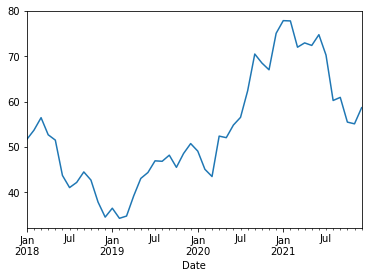

In [ ]:
series.plot()
plt.show()
# сезонности здесь нет, т.к. нет ежегодных колетаний, но тренд есть, ряд не стационарен

**4. Проверьте свою гипотезу с помощью расширенного теста Дики-Фуллера, воспользовавшись функцией adfuller() из модуля statsmodels.tsa.stattools. Прокомментируйте результат.**

In [ ]:
adfuller(series)
# p-value - это второе число (0.83369), H0(нулевая гипотеза) - рядне не стационарен
# p-value > 0.05, поэтому Н0 мы не отвергаем, т.е. ряд не стационарен

(-1.020451721292913,
 0.745732115708565,
 0,
 47,
 {'1%': -3.5778480370438146,
  '10%': -2.6007735310095064,
  '5%': -2.925338105429433},
 208.21462706219847)

0.83>0.05, поэтому H0 не отвергаем - ряд нестационарный.

**5. Проведите декомпозицию временного ряда на основе аддитивной модели, воспользовавшись функцией seasonal_decompose() из модуля statsmodels.tsa.seasonal. Результат представьте графически с помощью функций plot() и show() из модуля matplotlib.pyplot.**

In [ ]:
result=seasonal_decompose(series, model='additive', period=1)

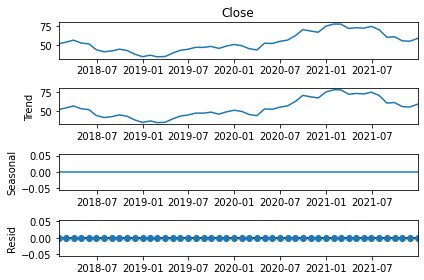

In [ ]:
result.plot() # 1.Исходный ряд, 2.Тренд, 3. Сезонность, 4. Ошибка
plt.show()

**6. Избавьтесь от тренда во временном ряду путем дифференцирования, в ходе которого строится новый ряд, в котором значение на текущем временном шаге рассчитывается, как разность между исходным наблюдением и наблюдением на предыдущем временном шаге: value(t) = observation(t) - observation(t - 1). Для этого возьмите значения временного ряда, обратившись к параметру values. Создайте список diff, в который поместите разность между исходным наблюдением и наблюдением на предыдущем временном шаге. Результат представьте графически с помощью функций plot() и show() из модуля matplotlib.pyplot. Прокомментируйте полученный результат.**

In [ ]:
X=series.values

In [ ]:
diff =list()

In [ ]:
for i in range(1,len(X)):
  value=X[i]-X[i-1]
  diff.append(value)

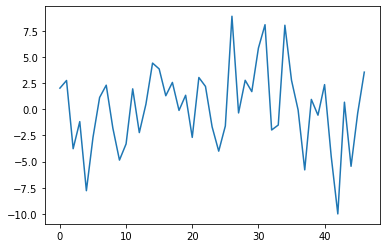

In [ ]:
plt.plot(diff) # ряд уже похож на стационарный, т.е. колебания вдоль горизогтальной оси, тренд ушел
plt.show()     # проверим гипотезу о стационарнрсти ряда!!!

**7. Проверьте полученный ряд diff на стационарность с помощью расширенного теста Дики-Фуллера, воспользовавшись функцией adfuller() из модуля statsmodels.tsa.stattools. Прокомментируйте результат.**

In [ ]:
adfuller(diff) # значение p-value оченнь мало, поэтому Н0 о том что ряд не стационарен - отвергаем

(-5.475411966002473,
 2.3477307533064087e-06,
 0,
 46,
 {'1%': -3.5812576580093696,
  '10%': -2.6015409829867675,
  '5%': -2.9267849124681518},
 203.98827666725336)

# **Ряд diff стационарный, d=1.**

**8. Если ряд не стационарный найдите вторую разность, путем дифференцирования ряда diff так же, как это описано в п. 6. Проверьте полученный ряд diff2 на стационарность так же, как это описано в п. 7. Если надо, повторите эти шаги. Остановитесь, когда ряд окажется стационарным. Сделайте предположение о d - порядке разности (дискретной производной) в модели ARIMA.**

In [ ]:
# т.е. проделываем тоже самое с теми же числами второй раз и трнтий раз, пока модель не станет стационарной

**9. На основе стационарного ряда постройте коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting и функцией show() из модуля matplotlib.pyplot. Сделайте предположение о p - порядке авторегрессионной составляющей в модели ARIMA.**

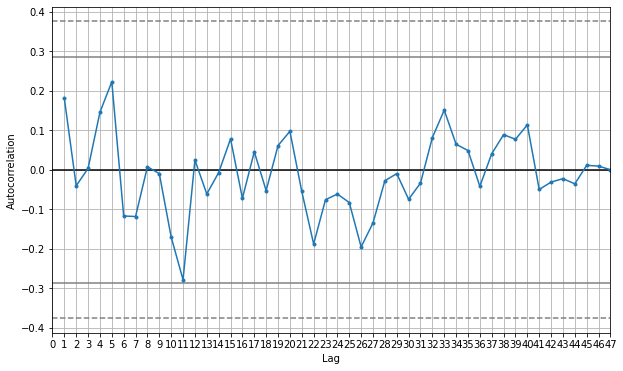

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

autocorrelation_plot(diff, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlim(0, len(diff))

plt.show()
# сплошная линия -  это уровень значимости одна сотая (0.01)
#пунктирная линия -  это уровень значимости пять сотых (0.05)
# присутствует автокорреляция при  тау = 1
# чаще всего берут уровень значимости 0.05

**10. На основе стационарного ряда постройте коррелограмму, воспользовавшись функцией plot_acf() из модуля statsmodels.graphics.tsaplots и функцией show() из модуля matplotlib.pyplot. Убедитесь в том, что получен такой же результат, что и в п.9.**

In [ ]:
# количество лагов взяли 12 (произвольно)

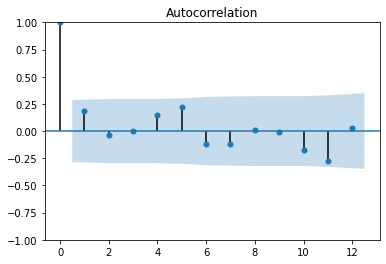

In [ ]:
plot_acf(diff, lags=12)
plt.show()
# автокорреляция наблюдается на шаге 1 и на грани на  шаге 2, поэтому
# наша гипотеза p = 1 и 2

**11. На основе стационарного ряда постройте частную автокорреляционную функцию, воспользовавшись функцией plot_pacf() из модуля statsmodels.graphics.tsaplots и функцией show() из модуля matplotlib.pyplot. Сделайте предположение о p - порядке авторегрессионной составляющей в модели ARIMA.**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


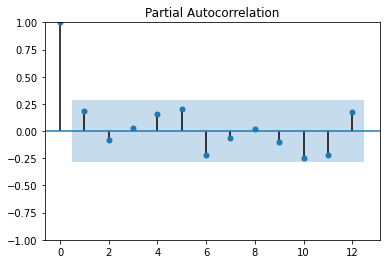

In [ ]:
plot_pacf(diff, lags=12)
plt.show()

# **Рассмотреть p=1**

**12. Рассчитайте максимальную величину лага (max_tau), как 4-ую часть объема выборки. Выведите результат на экран.**

In [ ]:
max_tau=int(len(diff)/4)
max_tau
# выходит от одного пикового значения до другого 11 зарубок

11

**13. Воспользуйтесь функцией ar_select_order() из модуля statsmodels.tsa.ar_model, чтобы определить оптимальный по критерию BIC порядок авторегрессии для стационарного ряда. Выведите результат на экран.**

In [ ]:
modelp=ar_select_order(diff, maxlag=max_tau,old_names=False)

In [ ]:
modelp.ar_lags
# здесь тоже 1, значит p надо брать p = 1

это d наверно

**14. По стационарному ряду постройте модель авторегрессии, порядок которой определен в п. 13. Способы построения авторегрессия смотрите в задании 7. Предпочтительно воспользоваться функцией AutoReg из модуля statsmodels.tsa.ar_model. Выведите на экран коэффициенты модели, расчетные и фактические значения для тестового набора, показатель качества RMSE и диаграмму с фактическими и расчетными значениями для тестовой выборки. Что Вы можете сказать о качестве построенной модели?**

In [ ]:
X=diff

In [ ]:
train, test = X[0:len(X)-12], X[len(X)-12:]

In [ ]:
model=AutoReg(train, lags=1,old_names=False) # т.е. строим авторегрессию строим первого порядка

In [ ]:
model_fit=model.fit()

In [ ]:
model_fit.params

array([0.54497687, 0.18498142])

In [ ]:
predictions=model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [ ]:
for i in range(len(predictions)): # распечатываем прогнозное и фактическое значения
  print('predicted=%f, expected=%f' %(predictions[i], test[i]))

predicted=2.034018, expected=2.789450
predicted=0.921232, expected=-0.061579
predicted=0.715388, expected=-5.794689
predicted=0.677310, expected=0.950779
predicted=0.670267, expected=-0.558643
predicted=0.668964, expected=2.366955
predicted=0.668723, expected=-4.494978
predicted=0.668678, expected=-10.010476
predicted=0.668670, expected=0.683810
predicted=0.668668, expected=-5.451905
predicted=0.668668, expected=-0.381905
predicted=0.668668, expected=3.561364


**15. Ошибки построенной модели можно найти, обратившись к ее параметру resid. Запишите результат в переменную err и выведите его на экран.**

In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE # похоже, что точная

4.434965738729965

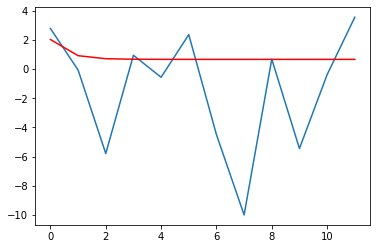

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

**16. По ряду ошибок постройте корреляционную и частную автокорреляционную функцию. Воспользуйтесь соответственно функциями plot_acf() и plot_pacf() из модуля statsmodels.graphics.tsaplots и функцией show() из модуля matplotlib.pyplot. Сделайте предположение о q - порядке скользящего среднего в модели ARIMA.**

In [ ]:
err=model_fit.resid
err

array([ 1.84192149, -4.82501828, -1.02405014, -8.11491994, -1.78347566,
        1.08883733,  1.55625474, -2.76700772, -5.071536  , -2.9554698 ,
        2.02877193, -3.13417802,  0.36643377,  3.79127697,  2.50322632,
        0.04203059,  1.79078346, -1.12252423,  0.82091671, -3.4784715 ,
        2.99984815,  1.08526653, -2.62084813, -4.23841379, -1.39837854,
        8.66167304, -2.5368338 ,  2.29944251,  0.63742479,  5.00198745,
        6.4732568 , -4.02153738, -1.67880788,  7.78211822])

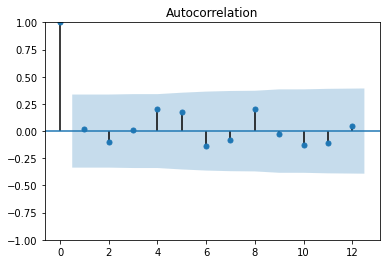

In [ ]:
plot_acf(err,lags=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


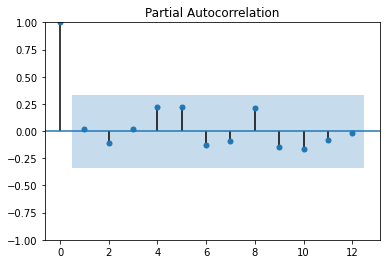

In [ ]:
plot_pacf(err,lags=12)
plt.show()

# **q=4?**

**17. Воспользуйтесь функцией ar_select_order() из модуля statsmodels.tsa.ar_model, чтобы определить оптимальный по критерию BIC порядок q для ряда ошибок. Прокомментируйте результат.**

In [ ]:
modelq=ar_select_order(err, maxlag=max_tau,old_names=False)

In [ ]:
modelq.ar_lags

# **q=0 (он говорит)**

# **p, d, q = 1, 1, 0 (4)**
p - это количество интегрирований (у нас с первого раза получилось)

**19. Оцените коэффициенты одной из моделей, воспользовавшись функцией ARIMA() из модуля statsmodels.tsa.arima_model. Обучите ее с помощью функции fit(). Выведите на экран описательные статистики по обученной модели с помощью функции summary(). Посмотрите на ошибки модели, обратившись к параметру resid. Постройте для них линейный график и функцию плотности распределения, воспользовавшись функциями plot() и show() из модуля matplotlib.pyplot. Выведите для ошибок описательные статистики, воспользовавшись функцией describe(). Прокомментируйте результат.**

In [ ]:
model=ARIMA(series, order=(11,2,0))

In [ ]:
model_fit=model.fit()

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   48
Model:                ARIMA(11, 2, 0)   Log Likelihood                -125.381
Date:                Fri, 22 Apr 2022   AIC                            274.762
Time:                        08:30:36   BIC                            296.705
Sample:                    01-31-2018   HQIC                           282.982
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6972      0.186     -3.752      0.000      -1.061      -0.333
ar.L2         -0.6165      0.238     -2.594      0.009      -1.082      -0.151
ar.L3         -0.5520      0.252     -2.191      0.0

In [ ]:
residuals=pd.DataFrame(model_fit.resid) # вытаскиваем ошибки

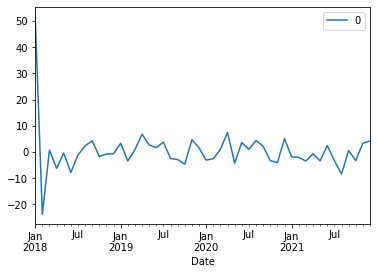

In [ ]:
residuals.plot()
plt.show()

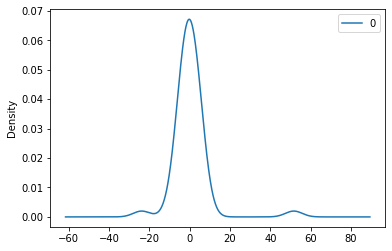

In [ ]:
residuals.plot(kind='kde') # график распределения ошибок
plt.show()

In [ ]:
residuals.describe()

,0
count,48.00
mean,0.41
std,9.05
min,-23.79
25%,-3.29
50%,-0.53
75%,2.85
max,51.64


**20. Проведите поиск по сетке (Grid Search) оптимальных с точки зрения критерия RMSE параметров p, d, q модели ARIMA. Выведите на экран лучший результат.**

In [ ]:
# grid search ARIMA parameters for time series
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 4, 5]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3, 4]
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


In [ ]:
model=ARIMA(series, order=(1,1,4))

In [ ]:
model_fit=model.fit()

In [ ]:
print(model_fit.summary()) #  чем больше  Log Likelihood, тем лучше
# P>|z|(хначимы ли коэффициенты), если меньше 0.05, то значимы, это хорошо

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   48
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -128.623
Date:                Fri, 22 Apr 2022   AIC                            269.246
Time:                        08:33:02   BIC                            280.347
Sample:                    01-31-2018   HQIC                           273.423
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6037      0.353      1.708      0.088      -0.089       1.296
ma.L1         -0.5254      0.391     -1.343      0.179      -1.292       0.242
ma.L2         -0.1180      0.173     -0.683      0.4

In [ ]:
residuals=pd.DataFrame(model_fit.resid)

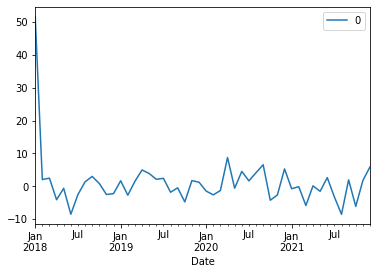

In [ ]:
residuals.plot()
plt.show()

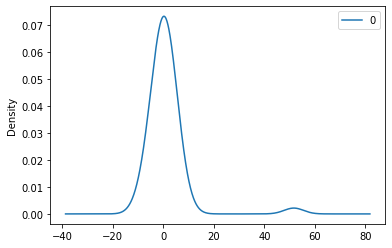

In [ ]:
residuals.plot(kind='kde')
plt.show()

In [ ]:
residuals.describe()

,0
count,48.000000
mean,0.210784
std,1.453440
min,-0.033772
25%,-0.011106
50%,-0.001860
75%,0.015477
max,10.070000


In [ ]:
model_fit.forecast(12)

2022-01-31    57.26
2022-02-28    54.40
2022-03-31    53.78
2022-04-30    54.89
2022-05-31    55.56
2022-06-30    55.96
2022-07-31    56.21
2022-08-31    56.35
2022-09-30    56.44
2022-10-31    56.50
2022-11-30    56.53
2022-12-31    56.55
Freq: M, Name: predicted_mean, dtype: float64

_____________________________________

# ***между линий фактическое значение за 4 месяца на 2022 год***

In [ ]:
df=data[['Date','Close']]

In [ ]:
df = df[-1082:-74] # выбралданные с 2018 года по 2021 включительно

In [ ]:
df_2022 = df[-74:]

In [ ]:
df_2022.shape

(74, 2)

In [ ]:
df_2022

,Date,Close
2947,2021-09-17,60.70
2948,2021-09-20,59.95
2949,2021-09-21,60.25
2950,2021-09-22,60.62
2951,2021-09-23,61.40
...,...,...
3016,2021-12-27,61.30
3017,2021-12-28,59.77
3018,2021-12-29,59.54
3019,2021-12-30,58.59


In [ ]:
df_2022.sample(4)

,Date,Close
3009,2021-12-15,58.92
3013,2021-12-21,60.92
2974,2021-10-26,53.65
3012,2021-12-20,59.23


In [ ]:
pd.set_option('precision', 2)

In [ ]:
df_2022.dtypes

Date      object
Close    float64
dtype: object

In [ ]:
df_2022['Date'] = pd.to_datetime(df_2022['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_2022.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [ ]:
df_2022=df_2022.set_index('Date')

In [ ]:
series_2022=df_2022.squeeze() # переводим DataFrame в Series для дальнейшей работы
series_2022.head(5)

Date
2021-09-17    60.70
2021-09-20    59.95
2021-09-21    60.25
2021-09-22    60.62
2021-09-23    61.40
Name: Close, dtype: float64

In [ ]:
series_2022.shape

(74,)

In [ ]:
series_2022=series_2022.resample('M').mean() # переход от помесечной разбивки к разбивке по дням

In [ ]:
series_2022.shape

(4,)

In [ ]:
series_2022

Date
2021-09-30    60.09
2021-10-31    55.46
2021-11-30    55.08
2021-12-31    58.64
Freq: M, Name: Close, dtype: float64

____________________________________________

# **Прогноз на следующий год:**

In [ ]:
i = model_fit.forecast(12)

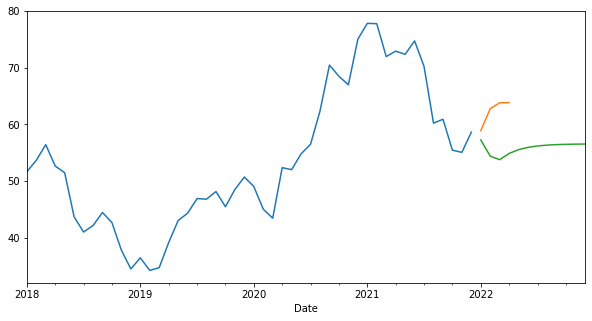

In [ ]:
plt.figure(figsize=(10, 5))
series.plot()
series_2022.plot()
i.plot()
plt.show()

# **Задание 9**

# **ЗАДАНИЕ 9. ПОСТРОЕНИЕ МОДЕЛИ МНК С ДИСКОНТИРОВАНИЕМ, МОДЕЛИ БРАУНА И МОДЕЛИ ХОЛЬТА**
Постройте линейный тренд, используя МНК с дисконтированием, по данным о среднедушевых денежных доходах населения (лист «Income»). Постройте по тому же ряду модель Брауна (модель экспоненциального сглаживания без тренда) и модель Хольта (модель экспоненциального сглаживания с трендом). Дайте прогноз доходов населения на год вперед по полученным моделям. Примите решение о том, какому из прогнозов стоит отдать предпочтение.
Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
import scipy
from scipy.optimize import differential_evolution, minimize

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/наборы данных')

In [ ]:
data=read_csv('nintendo.csv')

__________________________________________

# **ДАТАСЕТ**

In [ ]:
df=data[['Date','Close']]

In [ ]:
df = df[-1082:-74] # выбралданные с 2018 года по 2021 включительно

In [ ]:
df = df.drop(df.index[[300,550,551,800]])

In [ ]:
pd.set_option('precision', 2)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df=df.set_index('Date')

In [ ]:
series=df.squeeze() # переводим DataFrame в Series для дальнейшей работы
series.head(5)

Date
2018-01-02    45.90
2018-01-03    46.94
2018-01-04    48.53
2018-01-05    47.43
2018-01-08    47.56
Name: Close, dtype: float64

In [ ]:
series=series.resample('M').mean()

In [ ]:
df = series.reset_index()

In [ ]:
df = df.set_index('Date')

In [ ]:
df.shape

(48, 1)

_________________________________________

# **НАЧАЛО:**

# **Раздел 1. МНК с дисконтированием**

**1.	Произвольно в интервале от 0 до 2 задайте постоянную сглаживания α.**

______________________________________________________________________________

**способ нахождения экспоненциальной сглаженной *alpha* не методом подбора**

In [ ]:
model=SimpleExpSmoothing(df['Close'], initialization_method='estimated').fit()

In [ ]:
model.params_formatted

,name,param,optimized
smoothing_level,alpha,1.00,True
initial_level,l.0,51.64,True


______________________________________________________________

In [ ]:
alpha=1.2

**3.	В исходной таблице данных создайте столбец 't' с номерами наблюдений. Воспользуйтесь функцией array() из модуля numpy.**

In [ ]:
df['t']=np.array([i for i in range(1,len(df)+1)])

**4.	В той же таблице создайте новый столбец 'v', в котором рассчитайте веса соответствующих наблюдений υ_t (со ссылкой на столбец t и переменную α) по формуле: υ_t=α(1-α)^(T-t), где T – количество наблюдений, t – номер наблюдения.**

In [ ]:
df['v']=np.array([alpha*(1-alpha)**(len(df)-i) for i in range(1,len(df)+1)])

In [ ]:
df.head()

,Close,t,v
Date,,,
2018-01-31,51.64,1,6.75e-62
2018-02-28,53.67,2,1.35e-60
2018-03-31,56.44,3,2.70e-59
2018-04-30,52.67,4,5.40e-58
2018-05-31,51.49,5,1.08e-56


**5.	Рассчитайте значения коэффициентов a и b со ссылками на столбцы t, Y_t и υ_t по указанным ниже формулам:**


In [ ]:
b=(np.sum(df['t']*df['v']*df['Close'])-np.sum(df['t']*df['v'])*np.sum(df['Close']*df['v']))/(np.sum(np.power(df['t'],2)*df['v'])-np.power(np.sum(df['t']*df['v']),2))

In [ ]:
a=np.sum(df['Close']*df['v'])-b*np.sum(df['t']*df['v'])

In [ ]:
print(a,b)

-146.52046517164712 4.273531879308414


In [ ]:
df.tail()

,Close,t,v
Date,,,
2021-08-31,60.23,44,1.92e-03
2021-09-30,60.91,45,-9.60e-03
2021-10-31,55.46,46,4.80e-02
2021-11-30,55.08,47,-2.40e-01
2021-12-31,58.64,48,1.20e+00


In [ ]:
df.tail()

,Close,t,v
Date,,,
2021-08-31,60.23,44,5.94e-06
2021-09-30,60.91,45,1.19e-04
2021-10-31,55.46,46,2.38e-03
2021-11-30,55.08,47,4.75e-02
2021-12-31,58.64,48,9.50e-01


**7.	Вручную путем перебора подберите такое значение постоянной сглаживания α из интервала от 0 до 2, при которой линия тренда будет наилучшим образом описывать последние наблюдения. Запишите подобранное значение α.**

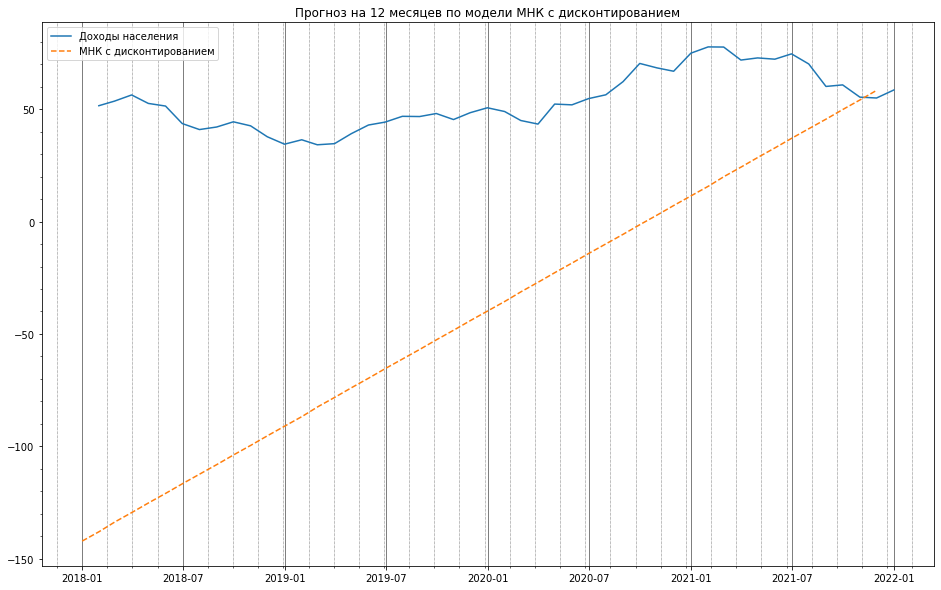

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Close'], label = 'Доходы населения')
ax.plot(a + b * pd.Series(np.array([i for i in range(1, len(df) + 1)]), pd.date_range(start='2018-01', end='2021-12', freq = 'MS')), label = 'МНК с дисконтированием', linestyle = '--')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели МНК с дисконтированием')

plt.show()

# **КОНЕЦ**

# **Раздел 2. Модель Брауна (модель экспоненциального сглаживания)**

# **НАЧАЛО**

**9.	Модель Брауна (модель экспоненциального сглаживания) имеет следующий вид: Y ̂_t=αY_t+(1-α) Y ̂_(t-1),**

**где Y ̂_(t-1) – расчетное значение по модели на предыдущем шаге,**

**Y_t – фактическое значение признака на текущем шаге.**

**10.	Задайте промежуток сглаживания – span. Выведите на экран его значение.**


In [ ]:
span=40 # параметри который подбирается

In [ ]:
!!!!!!!!!!!!!!!!!!! альфа можно подобать через промежуток сглаживания:

**10.	Рассчитайте постоянную сглаживания α по формуле: alfa=2/(span+1). Выведите на экран ее значение и прокомментируйте результат.**

In [ ]:
alfa=2/(span+1)
alfa

0.04878048780487805

**12.	К столбцу со значениями доходов населения примените функцию экспоненциального сглаживания ewm(), указав в качестве параметра span выбранный ранее интервал сглаживания, а также функцию mean(). Выведите на экран первые 5 наблюдений.**

In [ ]:
ema=df['Close'].ewm(span=span).mean()
ema.head()

Date
2018-01-31    51.64
2018-02-28    52.69
2018-03-31    54.00
2018-04-30    53.64
2018-05-31    53.17
Name: Close, dtype: float64

**13.	Нанесите на одну диаграмму фактические значения и значения по модели, воспользовавшись функциями subplots(), plot(), grid(), minorticks_on(), set_axisbelow(), legend(), title() и show() из модуля matplotlib.pyplot**

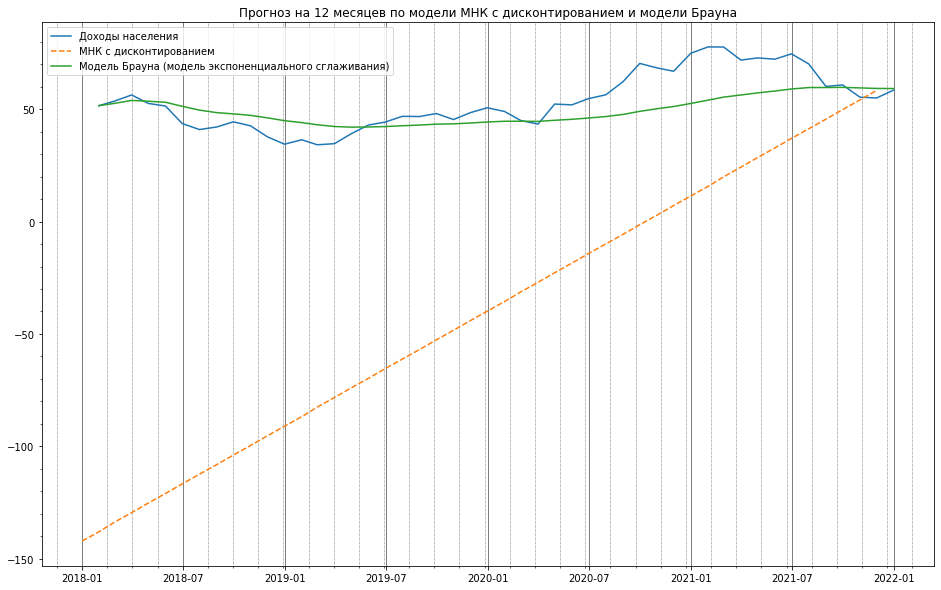

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Close'], label = 'Доходы населения')
ax.plot(a + b * pd.Series(np.array([i for i in range(1, len(df) + 1)]), pd.date_range(start='2018-01', end='2021-12', freq = 'MS')), label = 'МНК с дисконтированием', linestyle = '--')
ax.plot(ema,label='Модель Брауна (модель экспоненциального сглаживания)')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели МНК с дисконтированием и модели Брауна')

plt.show()

**14.	 Попробуйте изменить интервал сглаживания и построить модель заново. Как изменилась модель?**

In [ ]:
span=3 # параметри который подбирается

In [ ]:
!!!!!!!!!!!!!!!!!!! альфа можно подобать через промежуток сглаживания:

**10.	Рассчитайте постоянную сглаживания α по формуле: alfa=2/(span+1). Выведите на экран ее значение и прокомментируйте результат.**

In [ ]:
alfa=2/(span+1)
alfa

0.5

**12.	К столбцу со значениями доходов населения примените функцию экспоненциального сглаживания ewm(), указав в качестве параметра span выбранный ранее интервал сглаживания, а также функцию mean(). Выведите на экран первые 5 наблюдений.**

In [ ]:
ema=df['Close'].ewm(span=span).mean()
ema.head()

Date
2018-01-31    51.64
2018-02-28    53.00
2018-03-31    54.96
2018-04-30    53.74
2018-05-31    52.58
Name: Close, dtype: float64

**13.	Нанесите на одну диаграмму фактические значения и значения по модели, воспользовавшись функциями subplots(), plot(), grid(), minorticks_on(), set_axisbelow(), legend(), title() и show() из модуля matplotlib.pyplot**

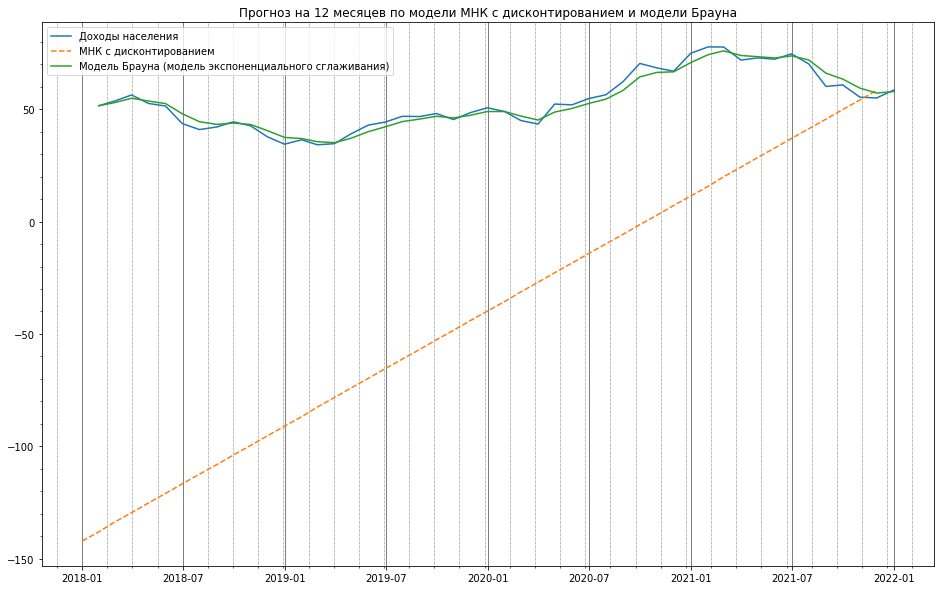

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Close'], label = 'Доходы населения')
ax.plot(a + b * pd.Series(np.array([i for i in range(1, len(df) + 1)]), pd.date_range(start='2018-01', end='2021-12', freq = 'MS')), label = 'МНК с дисконтированием', linestyle = '--')
ax.plot(ema,label='Модель Брауна (модель экспоненциального сглаживания)')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели МНК с дисконтированием и модели Брауна')

plt.show()

**15. Постройте модель экспоненциального сглаживания с помощью функции SimpleExpSmoothing() из модуля statsmodels.tsa.api. Обучите ее с помощью функции fit(). Выведите на экран подобранную автоматически постоянную сглаживания α, обратившись к параметру обученной модели params_formatted. Прокомментируйте результат.**

**способ нахождения экспоненциальной сглаженной *alpha***

______________________________________________________________________________

# **Создаем, обучаем модель:**

In [ ]:
model=SimpleExpSmoothing(df['Close'], initialization_method='estimated').fit()

______________________________________________________________

In [ ]:
model.params_formatted

,name,param,optimized
smoothing_level,alpha,1.00,True
initial_level,l.0,51.64,True


**16.	Рассчитанные по модели значения находятся в параметре fittedvalues. Выведите на экран первые 5 наблюдений.**

In [ ]:
y_pred=model.fittedvalues
y_pred.head()

Date
2018-01-31    51.64
2018-02-28    51.64
2018-03-31    53.67
2018-04-30    56.44
2018-05-31    52.67
dtype: float64

In [ ]:
y=df['Close']
y.head()

Date
2018-01-31    51.64
2018-02-28    53.67
2018-03-31    56.44
2018-04-30    52.67
2018-05-31    51.49
Name: Close, dtype: float64

In [ ]:
MSE=mean_squared_error(y, y_pred)
MSE

14.765574250301684

In [ ]:
RMSE=sqrt(MSE)
RMSE

3.8425999336779366

# **1-й вариант вывести прогноз:**

In [ ]:
model.predict(start=48, end=59)

2022-01-31    58.64
2022-02-28    58.64
2022-03-31    58.64
2022-04-30    58.64
2022-05-31    58.64
2022-06-30    58.64
2022-07-31    58.64
2022-08-31    58.64
2022-09-30    58.64
2022-10-31    58.64
2022-11-30    58.64
2022-12-31    58.64
Freq: M, dtype: float64

# **2-й вариант вывести прогноз:**

In [ ]:
model.forecast(12)

2022-01-31    58.64
2022-02-28    58.64
2022-03-31    58.64
2022-04-30    58.64
2022-05-31    58.64
2022-06-30    58.64
2022-07-31    58.64
2022-08-31    58.64
2022-09-30    58.64
2022-10-31    58.64
2022-11-30    58.64
2022-12-31    58.64
Freq: M, dtype: float64

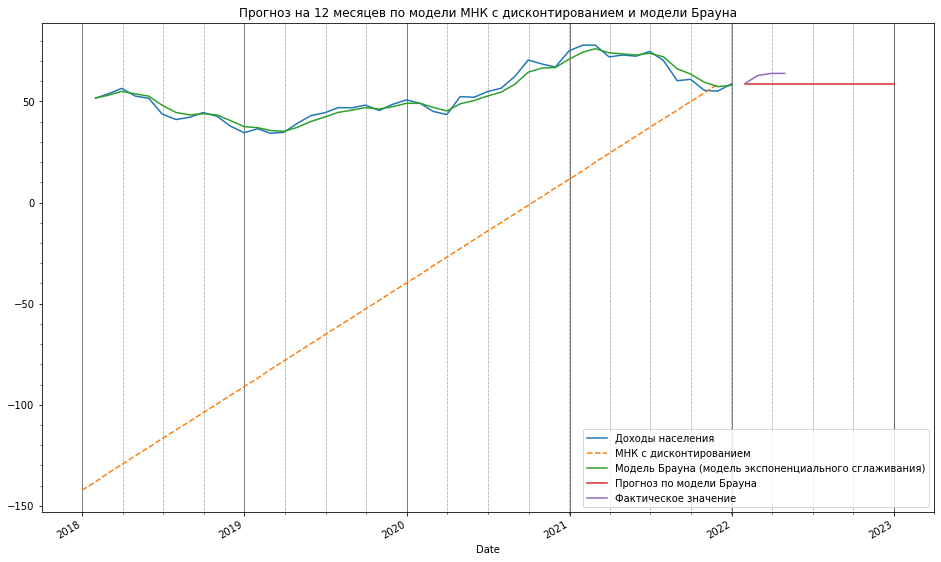

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Close'], label = 'Доходы населения')
ax.plot(a + b * pd.Series(np.array([i for i in range(1, len(df) + 1)]), pd.date_range(start='2018-01', end='2021-12', freq = 'MS')), label = 'МНК с дисконтированием', linestyle = '--')
ax.plot(ema,label='Модель Брауна (модель экспоненциального сглаживания)')
ax.plot(model.predict(start=48, end=59), label='Прогноз по модели Брауна')
series_2022.plot(label='Фактическое значение')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели МНК с дисконтированием и модели Брауна')

plt.show()

# **КОНЕЦ**

# **Раздел 3. Модель Хольта (модель экспоненциального сглаживания с линейным трендом)**

# **НАЧАЛО**

__________________________________________

# **ДАТАСЕТ**

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/наборы данных')

In [ ]:
data=read_csv('nintendo.csv')

In [ ]:
df=data[['Date','Close']]

In [ ]:
df = df[-1082:-74] # выбралданные с 2018 года по 2021 включительно

In [ ]:
df = df.drop(df.index[[300,550,551,800]])

In [ ]:
pd.set_option('precision', 2)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df=df.set_index('Date')

In [ ]:
series=df.squeeze() # переводим DataFrame в Series для дальнейшей работы
series.head(5)

Date
2018-01-02    45.90
2018-01-03    46.94
2018-01-04    48.53
2018-01-05    47.43
2018-01-08    47.56
Name: Close, dtype: float64

In [ ]:
series=series.resample('M').mean()

In [ ]:
df = series.reset_index()

In [ ]:
df = df.set_index('Date')

In [ ]:
df.shape

(48, 1)

_________________________________________

In [ ]:
df.head(5)

,Close
Date,
2018-01-31,51.64
2018-02-28,53.67
2018-03-31,56.44
2018-04-30,52.67
2018-05-31,51.49


**20.	 Постройте модель Хольта, обратившись к столбцу с данными о доходах населения и воспользовавшись функцией Holt() из модуля statsmodels.tsa.holtwinters. Обучите модель с помощью функции fit().**

In [ ]:
model_2=Holt(df['Close'], initialization_method="estimated").fit()

**21.	Рассчитанные по модели значения находятся в параметре fittedvalues. Выведите на экран первые 5 наблюдений.**

In [ ]:
y_pred=model_2.fittedvalues
y_pred.head()

Date
2018-01-31    51.64
2018-02-28    51.79
2018-03-31    53.82
2018-04-30    56.59
2018-05-31    52.82
dtype: float64

In [ ]:
y=df['Close']
y.head()

Date
2018-01-31    51.64
2018-02-28    53.67
2018-03-31    56.44
2018-04-30    52.67
2018-05-31    51.49
Name: Close, dtype: float64

**22.	Оцените по всем данным точность модели с помощью показателя RMSE, обратившись к функции sqrt() из модуля math и функции mean_squared_error() из модуля sklearn.metrics. Прокомментируйте результат.**

In [ ]:
MSE=mean_squared_error(y, y_pred)
MSE

14.74387550690543

In [ ]:
RMSE=sqrt(MSE)
RMSE

3.839775450062859

**23.	Дайте прогноз доходов населения на год вперед, воспользовавшись функцией predict(), в которой нужно задать номер начального (start) и конечного наблюдения (end). Либо можно воспользоваться функцией forecast(), указав в ней количество прогнозных наблюдений. Что Вы можете сказать о динамике прогнозных значений?**

# **1-й вариант вывести прогноз:**

In [ ]:
model_2.predict(start=48, end=59)

2022-01-31    58.79
2022-02-28    58.94
2022-03-31    59.09
2022-04-30    59.24
2022-05-31    59.39
2022-06-30    59.53
2022-07-31    59.68
2022-08-31    59.83
2022-09-30    59.98
2022-10-31    60.13
2022-11-30    60.28
2022-12-31    60.43
Freq: M, dtype: float64

# **2-й вариант вывести прогноз:**

In [ ]:
y_new=model_2.forecast(12)
y_new

2022-01-31    58.79
2022-02-28    58.94
2022-03-31    59.09
2022-04-30    59.24
2022-05-31    59.39
2022-06-30    59.53
2022-07-31    59.68
2022-08-31    59.83
2022-09-30    59.98
2022-10-31    60.13
2022-11-30    60.28
2022-12-31    60.43
Freq: M, dtype: float64

**24.	 Нанесите на одну диаграмму фактические значения, значения по модели и точечный прогноз, воспользовавшись функциями subplots(), plot(), grid(), minorticks_on(), set_axisbelow(), legend(), title() и show() из модуля matplotlib.pyplot.**

______________________________________

# **!!!ТАК МОЖНО СОХРАНИТЬ ЛУЧШий ПРОГНОЗ В ФАЙЛ**

In [ ]:
np.save('income_new.npy',model.forecast(12)) # сохранили в файл значение прогноза для задания 11

____________________________________________

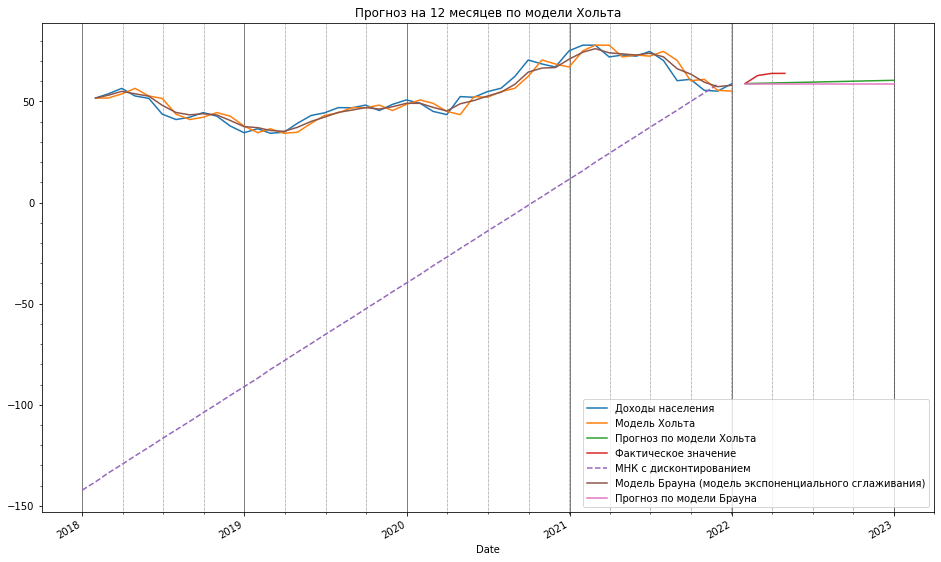

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Close'], label = 'Доходы населения')
ax.plot(y_pred, label = 'Модель Хольта')
ax.plot(model_2.forecast(12), label = 'Прогноз по модели Хольта')
series_2022.plot(label='Фактическое значение')
ax.plot(a + b * pd.Series(np.array([i for i in range(1, len(df) + 1)]), pd.date_range(start='2018-01', end='2021-12', freq = 'MS')), label = 'МНК с дисконтированием', linestyle = '--')
ax.plot(ema,label='Модель Брауна (модель экспоненциального сглаживания)')
ax.plot(model.predict(start=48, end=59), label='Прогноз по модели Брауна')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели Хольта')

plt.show()

In [ ]:
sigma=scipy.stats.sem(y)
sigma

1.8095878000202659

In [ ]:
conf=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1+conf)/2.,len(y)-1)
tstu

2.0117405104757546

In [ ]:
y_up=y_new+tstu*sigma
y_up

2022-01-31    62.43
2022-02-28    62.58
2022-03-31    62.73
2022-04-30    62.88
2022-05-31    63.03
2022-06-30    63.17
2022-07-31    63.32
2022-08-31    63.47
2022-09-30    63.62
2022-10-31    63.77
2022-11-30    63.92
2022-12-31    64.07
Freq: M, dtype: float64

In [ ]:
np.save('income_up.npy',y_up)

In [ ]:
y_down=y_new-tstu*sigma
y_down

2022-01-31    55.15
2022-02-28    55.30
2022-03-31    55.45
2022-04-30    55.60
2022-05-31    55.75
2022-06-30    55.89
2022-07-31    56.04
2022-08-31    56.19
2022-09-30    56.34
2022-10-31    56.49
2022-11-30    56.64
2022-12-31    56.79
Freq: M, dtype: float64

In [ ]:
np.save('income_down.npy',y_down)

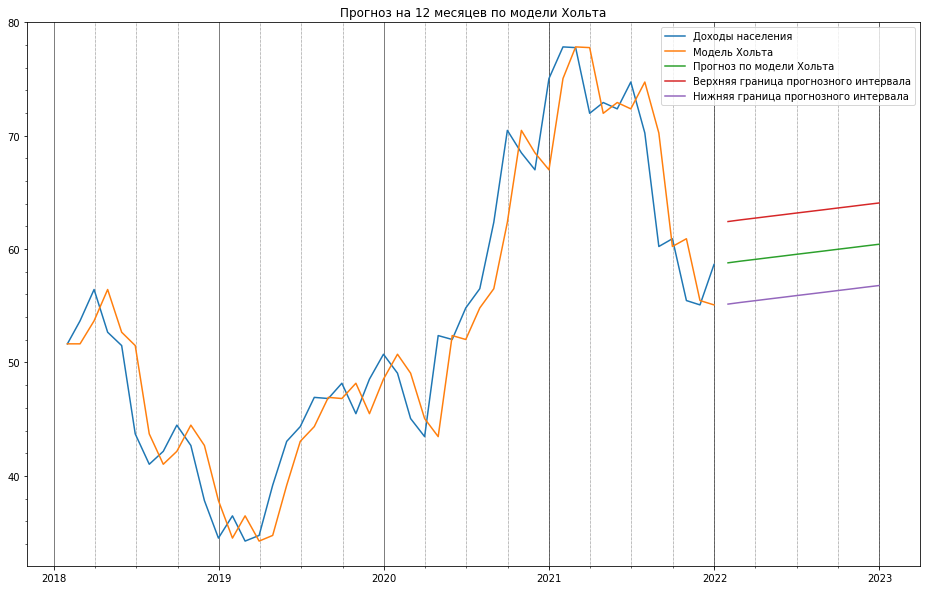

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))
ax.plot(df['Close'], label = 'Доходы населения')
ax.plot(y_pred, label = 'Модель Хольта')
ax.plot(model_2.forecast(12), label = 'Прогноз по модели Хольта')
ax.plot(y_up, label = 'Верхняя граница прогнозного интервала')
ax.plot(y_down, label = 'Нижняя граница прогнозного интервала')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели Хольта')

plt.show()

# **КОНЕЦ**

# Задание 10

# **ЗАДАНИЕ 10. ПОСТРОЕНИЕ МОДЕЛИ ХОЛЬТА-УИНТЕРСА И МОДЕЛИ ТЕЙЛА-ВЕЙДЖА**
Постройте модель Хольта-Уинтерса по рыночным ценам на продукцию организации (лист «prices»). Постройте по тому же ряду модель Тейла-Вейджа. Выберите лучшую модель для прогнозирования. Дайте точечный и интервальные прогнозы рыночных цен на период с января по декабрь 2011 года.
Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.



In [ ]:
!pip install --upgrade xlrd

In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 22.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import os
import pandas as pd
from pandas import read_csv
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import differential_evolution, minimize
import scipy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


__________________________________________

# **ДАТАСЕТ**

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/наборы данных')

In [ ]:
data=read_csv('nintendo.csv')

In [ ]:
df=data[['Date','Close']]

In [ ]:
df = df[-1082:-74] # выбралданные с 2018 года по 2021 включительно

In [ ]:
df = df.drop(df.index[[300,550,551,800]])

In [ ]:
pd.set_option('precision', 2)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df=df.set_index('Date')

In [ ]:
series=df.squeeze() # переводим DataFrame в Series для дальнейшей работы
series.head(5)

Date
2018-01-02    45.90
2018-01-03    46.94
2018-01-04    48.53
2018-01-05    47.43
2018-01-08    47.56
Name: Close, dtype: float64

In [ ]:
series=series.resample('M').mean()

In [ ]:
df = series.reset_index()

In [ ]:
df = df.set_index('Date')

In [ ]:
df.shape

(48, 1)

_________________________________________

# **Раздел 1. Модель Хольта-Уинтерса**

# **НАЧАЛО**

In [ ]:
df.head()

,Close
Date,
2018-01-31,51.64
2018-02-28,53.67
2018-03-31,56.44
2018-04-30,52.67
2018-05-31,51.49


**2.	Постройте модель Хольта-Уинтерса, обратившись к столбцу с данными о рыночных ценах на продукцию организации и воспользовавшись функцией ExponentialSmoothing(data,seasonal='multiplicative',initialization_method="estimated") из модуля statsmodels.tsa.holtwinters. В параметре seasonal укажите, что это мультипликативная модель. Обучите модель с помощью функции fit(). Результат запишите в переменную model.**

In [ ]:
model=ExponentialSmoothing(df['Close'],seasonal='multiplicative',initialization_method="estimated").fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


**3.	Рассчитанные по модели значения находятся в параметре fittedvalues. Обратитесь к нему. Результат запишите в переменную y_pred. Выведите на экран первые 5 наблюдений.**

In [ ]:
y_pred=model.fittedvalues
y_pred.head()

Date
2018-01-31    51.64
2018-02-28    50.85
2018-03-31    52.04
2018-04-30    58.33
2018-05-31    52.74
dtype: float64

**4.	Запишите в переменную y фактические значения доходов населения.**

In [ ]:
y=df['Close']
y.head()

Date
2018-01-31    51.64
2018-02-28    53.67
2018-03-31    56.44
2018-04-30    52.67
2018-05-31    51.49
Name: Close, dtype: float64

**5.	Оцените по всем данным точность модели с помощью показателя RMSE, обратившись к функции sqrt() из модуля math и функции mean_squared_error(y, y_pred) из модуля sklearn.metrics. Прокомментируйте результат.**

In [ ]:
MSE=mean_squared_error(y, y_pred)
MSE

11.173082929968821

In [ ]:
RMSE=sqrt(MSE)
RMSE

3.3426161804743333

**6.	Дайте прогноз рыночных цен на продукцию организации на год вперед, воспользовавшись функцией predict(start=start, end=end), в которой нужно задать номер начального (start) и конечного наблюдения (end). Результат запишите в переменную y_new. Выведите на экран ее содержимое.**

In [ ]:
y_new=model.predict(start=48, end=59)
y_new

2022-01-31    59.76
2022-02-28    58.85
2022-03-31    57.05
2022-04-30    58.97
2022-05-31    59.05
2022-06-30    58.85
2022-07-31    57.63
2022-08-31    55.98
2022-09-30    59.37
2022-10-31    56.19
2022-11-30    55.20
2022-12-31    58.64
Freq: M, dtype: float64

**7.	Также для прогнозирования можно воспользоваться функцией forecast(), указав в ней количество прогнозных наблюдений. Запишите результат в переменную y_new и выведите его на экран.**

In [ ]:
y_new=model.forecast(12)
y_new

2022-01-31    59.76
2022-02-28    58.85
2022-03-31    57.05
2022-04-30    58.97
2022-05-31    59.05
2022-06-30    58.85
2022-07-31    57.63
2022-08-31    55.98
2022-09-30    59.37
2022-10-31    56.19
2022-11-30    55.20
2022-12-31    58.64
Freq: M, dtype: float64

In [ ]:
np.save('prices_new.npy',y_new)

**8.	Рассчитайте среднее квадратичное отклонение, воспользовавшись функцией sem() из модуля scipy.stats. Запишите результат в переменную sigma и выведите его на экран.**

In [ ]:
sigma=scipy.stats.sem(y)
sigma

1.8095878000202659

In [ ]:
conf=0.95

**9.	Рассчитайте двусторонний t критерий Стьюдента для существующего объема выборки и 95% достоверности результата (confidence). Воспользуйтесь функцией t.ppf((1 + confidence) / 2., len(y)-1) из модуля scipy.stats. Запишите результат в переменную tstu и выведите его на экран.**

In [ ]:
tstu=scipy.stats.t.ppf((1+conf)/2.,len(y)-1)
tstu

2.0117405104757546

**10.	Рассчитайте верхнюю границу прогнозного интервала, воспользовавшись формулой: y_up=y_new+tstu*sigma. Выведите результат на экран.**

In [ ]:
y_up=y_new+tstu*sigma
y_up

2022-01-31    63.40
2022-02-28    62.49
2022-03-31    60.69
2022-04-30    62.61
2022-05-31    62.69
2022-06-30    62.49
2022-07-31    61.27
2022-08-31    59.62
2022-09-30    63.01
2022-10-31    59.83
2022-11-30    58.84
2022-12-31    62.28
Freq: M, dtype: float64

In [ ]:
np.save('prices_up.npy',y_up)

**11.	Рассчитайте нижнюю границу прогнозного интервала, воспользовавшись формулой: y_down=y_new-tstu*sigma. Выведите результат на экран.**

In [ ]:
y_down=y_new-tstu*sigma
y_down

2022-01-31    56.12
2022-02-28    55.21
2022-03-31    53.41
2022-04-30    55.33
2022-05-31    55.41
2022-06-30    55.21
2022-07-31    53.99
2022-08-31    52.34
2022-09-30    55.73
2022-10-31    52.55
2022-11-30    51.56
2022-12-31    55.00
Freq: M, dtype: float64

In [ ]:
np.save('prices_down.npy',y_down)

**12.	Нанесите на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями subplots(), plot(), grid(), minorticks_on(), set_axisbelow(), legend(), title() и show() из модуля matplotlib.pyplot.**

In [ ]:
import matplotlib.pyplot as plt


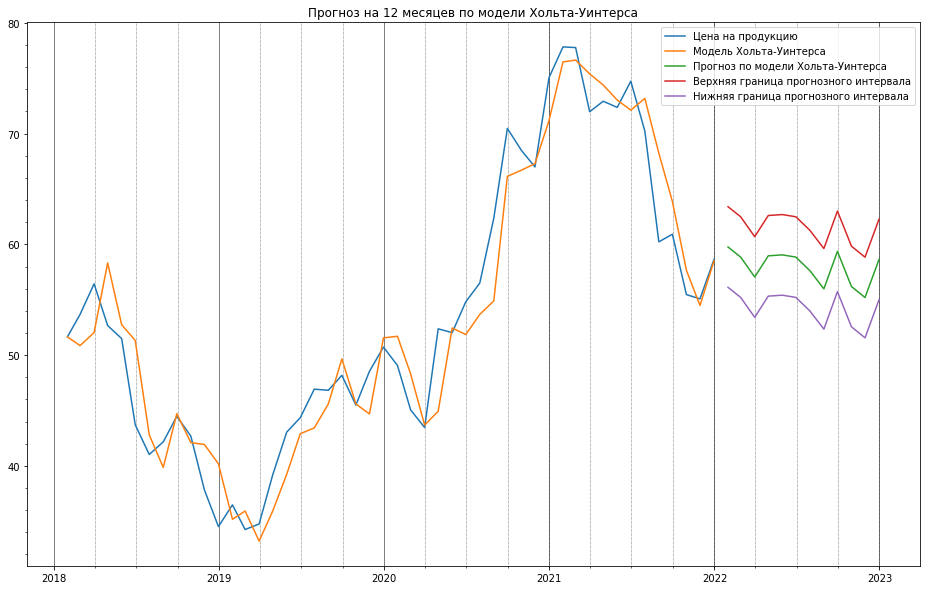

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Close'], label = 'Цена на продукцию')
ax.plot(y_pred, label = 'Модель Хольта-Уинтерса')
ax.plot(y_new, label = 'Прогноз по модели Хольта-Уинтерса')
ax.plot(y_up, label = 'Верхняя граница прогнозного интервала')
ax.plot(y_down, label = 'Нижняя граница прогнозного интервала')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели Хольта-Уинтерса')

plt.show()

# **КОНЕЦ**

# **Раздел 2. Модель Тейла-Вейджа**

**13.	 Постройте модель Тейла-Вейджа, обратившись к столбцу с данными о рыночных ценах на продукцию организации и воспользовавшись функцией ExponentialSmoothing(data,seasonal='additive',initialization_method="estimated") из модуля statsmodels.tsa.holtwinters. В параметре seasonal укажите, что это аддитивная модель. Обучите модель с помощью функции fit(). Результат запишите в переменную model.**

In [ ]:
model=ExponentialSmoothing(df['Close'],seasonal='additive',initialization_method="estimated").fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


**14.	Рассчитанные по модели значения находятся в параметре fittedvalues. Обратитесь к нему. Результат запишите в переменную y_pred. Выведите на экран первые 5 наблюдений.**

In [ ]:
y_pred=model.fittedvalues
y_pred.head()

Date
2018-01-31    51.64
2018-02-28    50.42
2018-03-31    52.48
2018-04-30    58.91
2018-05-31    52.95
dtype: float64

In [ ]:
y=df['Close']
y.head()

Date
2018-01-31    51.64
2018-02-28    53.67
2018-03-31    56.44
2018-04-30    52.67
2018-05-31    51.49
Name: Close, dtype: float64

**15.	Оцените по всем данным точность модели с помощью показателя RMSE, обратившись к функции sqrt() из модуля math и функции mean_squared_error(y, y_pred) из модуля sklearn.metrics. Прокомментируйте результат.**

In [ ]:
MSE=mean_squared_error(y, y_pred)
MSE

11.656681300790261

In [ ]:
RMSE=sqrt(MSE)
RMSE

3.414188234528123

**16.	Дайте прогноз рыночных цен на продукцию организации на год вперед, воспользовавшись функцией predict(start=start, end=end), в которой нужно задать номер начального (start) и конечного наблюдения (end).**

In [ ]:
y_new=model.predict(start=48, end=59)
y_new

2022-01-31    59.45
2022-02-28    58.22
2022-03-31    57.03
2022-04-30    59.50
2022-05-31    59.78
2022-06-30    59.29
2022-07-31    58.40
2022-08-31    57.46
2022-09-30    60.41
2022-10-31    57.27
2022-11-30    56.18
2022-12-31    58.64
Freq: M, dtype: float64

**17.	Также для прогнозирования можно воспользоваться функцией forecast(), указав в ней количество прогнозных наблюдений. Запишите результат в переменную y_new и выведите его на экран.**

In [ ]:
y_new=model.forecast(12)
y_new

2022-01-31    59.45
2022-02-28    58.22
2022-03-31    57.03
2022-04-30    59.50
2022-05-31    59.78
2022-06-30    59.29
2022-07-31    58.40
2022-08-31    57.46
2022-09-30    60.41
2022-10-31    57.27
2022-11-30    56.18
2022-12-31    58.64
Freq: M, dtype: float64

In [ ]:
np.save('prices_new.npy',y_new)

**18.	Рассчитайте среднее квадратичное отклонение, воспользовавшись функцией sem() из модуля scipy.stats. Запишите результат в переменную sigma и выведите его на экран.**

In [ ]:
sigma=scipy.stats.sem(y)
sigma

1.8095878000202659

**19.	Рассчитайте двусторонний t критерий Стьюдента для существующего объема выборки и 95% достоверности результата (confidence). Воспользуйтесь функцией t.ppf((1 + confidence) / 2., len(y)-1) из модуля scipy.stats. Запишите результат в переменную tstu и выведите его на экран.**

In [ ]:
conf=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1+conf)/2.,len(y)-1)
tstu

2.0117405104757546

**20.	Рассчитайте верхнюю границу прогнозного интервала, воспользовавшись формулой: y_up=y_new+tstu*sigma. Выведите результат на экран.**

In [ ]:
y_up=y_new+tstu*sigma
y_up

2022-01-31    63.09
2022-02-28    61.86
2022-03-31    60.67
2022-04-30    63.14
2022-05-31    63.42
2022-06-30    62.93
2022-07-31    62.04
2022-08-31    61.10
2022-09-30    64.05
2022-10-31    60.91
2022-11-30    59.82
2022-12-31    62.28
Freq: M, dtype: float64

In [ ]:
np.save('prices_up.npy',y_up)

**21.	Рассчитайте нижнюю границу прогнозного интервала, воспользовавшись формулой: y_down=y_new-tstu*sigma. Выведите результат на экран.**

In [ ]:
y_down=y_new-tstu*sigma
y_down

2022-01-31    55.81
2022-02-28    54.58
2022-03-31    53.39
2022-04-30    55.86
2022-05-31    56.14
2022-06-30    55.64
2022-07-31    54.76
2022-08-31    53.82
2022-09-30    56.76
2022-10-31    53.63
2022-11-30    52.54
2022-12-31    55.00
Freq: M, dtype: float64

In [ ]:
np.save('prices_down.npy',y_down)

**22.	Нанесите на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями subplots(), plot(), grid(), minorticks_on(), set_axisbelow(), legend(), title() и show() из модуля matplotlib.pyplot.**

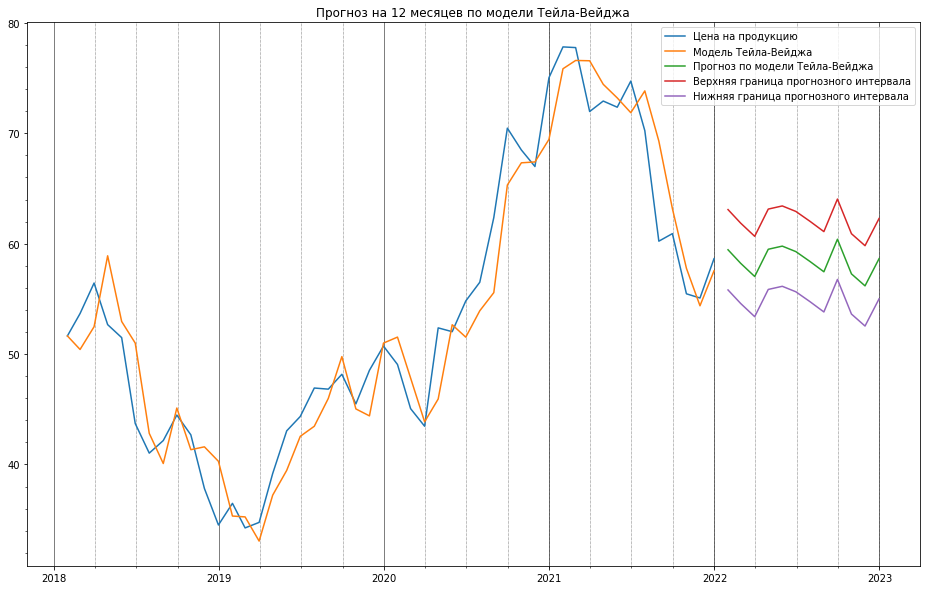

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Close'], label = 'Цена на продукцию')
ax.plot(y_pred, label = 'Модель Тейла-Вейджа')
ax.plot(y_new, label = 'Прогноз по модели Тейла-Вейджа')
ax.plot(y_up, label = 'Верхняя граница прогнозного интервала')
ax.plot(y_down, label = 'Нижняя граница прогнозного интервала')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели Тейла-Вейджа')

plt.show()

# Задание 11

**ЗАДАНИЕ 11. ПОСТРОЕНИЕ МОДЕЛИ СТОХАСТИЧЕСКОЙ АППРОКСИМАЦИИ**

Постройте регрессионную модель методом стохастической аппроксимации по рядам продаж продукции («Sales»), среднедушевых доходов («Income») и рыночных цен («Prices»). Используя полученную модель, дайте прогноз на год вперед.
Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.


In [ ]:
!pip install --upgrade xlrd

In [ ]:
import os
import numpy as np
from pandas import read_excel
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/PDA-210')

In [ ]:
dataS=pd.read_excel('data.xls', sheet_name='Sales')
dataP=pd.read_excel('data.xls', sheet_name='Prices')
dataI=pd.read_excel('data.xls', sheet_name='Income')

ImportError: ignored

In [ ]:
sales = dataS.values[1,2:]
prices = dataP.values[1,2:]
income = dataI.values[1,2:]

In [ ]:
X=list(zip(income, prices))

In [ ]:
y=sales

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
model=LinearRegression()

In [ ]:
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
model.intercept_

14460.717103497842

In [ ]:
model.coef_

array([ -0.30091117, 154.36290897])

In [ ]:
a0=[model.intercept_]
a0

[14460.717103497842]

In [ ]:
a1=[model.coef_[0]]
a1

[-0.3009111676409663]

In [ ]:
a2=[model.coef_[1]]
a2

[154.3629089701766]

In [ ]:
np.mean(sales)

20662.791666666668

In [ ]:
l=0.1

In [ ]:
nu=l*np.mean(sales)
nu

2066.2791666666667

In [ ]:
k=3
v=1/k
v

0.3333333333333333

In [ ]:
sales_sa =[]
borderu = []
borderd = []
error = []
gamma = []

In [ ]:
sales_sa.append(a0[0]+a1[0]*income[0]+a2[0]*prices[0])
sales_sa

[20927.494423916865]

In [ ]:
error.append(sales[0]-sales_sa[0])
error

[372.50557608313466]

In [ ]:
gamma.append(v*abs((abs(error[0])-nu)/error[0]))
gamma

[1.515658376977352]

In [ ]:
borderu.append(sales_sa[0]+nu)
borderu

[22993.773590583532]

In [ ]:
borderd.append(sales_sa[0]-nu)
borderd

[18861.2152572502]

In [ ]:
for i in range(1,len(sales)):
  if abs(error[i-1])>nu:
    a0.append(a0[i-1]+gamma[i-1]*error[i-1])
    a1.append(a1[i-1]+gamma[i-1]*error[i-1]/income[i-1])
    a2.append(a2[i-1]+gamma[i-1]*error[i-1]/prices[i-1])
  else:
    a0.append(a0[i-1])
    a1.append(a1[i-1])
    a2.append(a2[i-1])
  sales_sa.append(a0[i]+a1[i]*income[i]+a2[i]*prices[i])
  error.append(sales[i]-sales_sa[i])
  gamma.append(v*abs((abs(error[i])-nu)/error[i]))
  borderu.append(sales_sa[i]+nu)
  borderd.append(sales_sa[i]-nu)

In [ ]:
income_new=np.load('income_new.npy')
income_new

array([16469.20253334, 16626.13808955, 16783.07364576, 16940.00920197,
       17096.94475818, 17253.88031438, 17410.81587059, 17567.7514268 ,
       17724.68698301, 17881.62253922, 18038.55809542, 18195.49365163])

In [ ]:
prices_new=np.load('prices_new.npy')
prices_new

array([79.14359603, 77.69263114, 73.08666994, 68.09320422, 63.5772429 ,
       59.90877662, 60.20530802, 66.44934708, 68.41338496, 74.52242016,
       77.77645538, 82.05799152])

In [ ]:
sales_new=a0[47]+a1[47]*income_new+a2[47]*prices_new

In [ ]:
sales_up=sales_new+nu

In [ ]:
sales_down=sales_new-nu

In [ ]:
t=np.arange(1,len(y)+1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [ ]:
t_new=np.arange(len(y)+1,len(y)+13)
t_new

array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

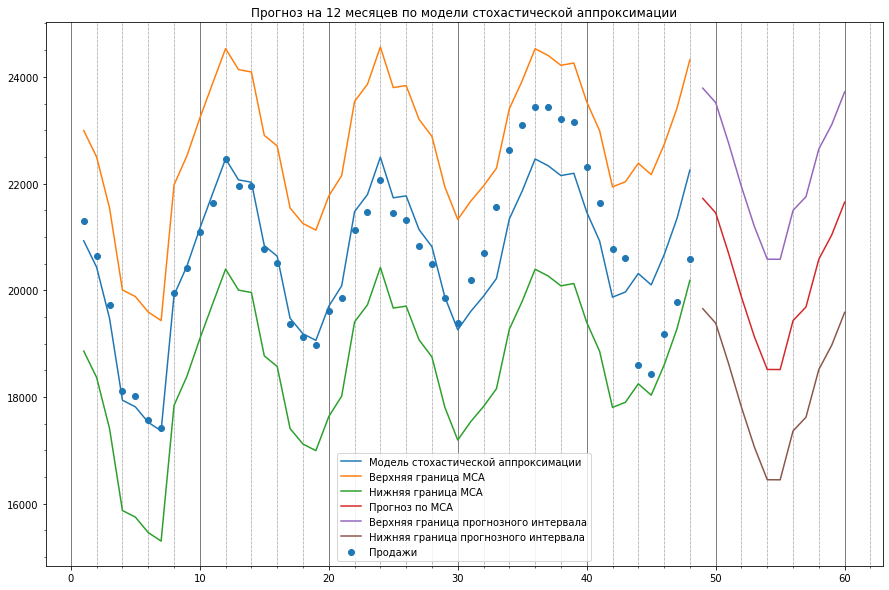

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

ax.scatter(t, sales, label = 'Продажи')
ax.plot(t, sales_sa, label = 'Модель стохастической аппроксимации')
ax.plot(t, borderu, label = 'Верхняя граница МСА')
ax.plot(t, borderd, label = 'Нижняя граница МСА')
ax.plot(t_new, sales_new, label = 'Прогноз по МСА')
ax.plot(t_new, sales_up, label = 'Верхняя граница прогнозного интервала')
ax.plot(t_new, sales_down, label = 'Нижняя граница прогнозного интервала')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели стохастической аппроксимации')

plt.show()